In [23]:

from keras.applications import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
#from keras.applications.inception_v3 import preprocess_input
import numpy as np
import tensorflow as tf
from PIL import Image

In [24]:
def preprocess_input_cropper(image):
    image = preprocess_input(image)
    

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split=0.2,preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory( directory="../Data/car_data/train", target_size=(224, 224), 
    color_mode="rgb" , 
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

train_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)
test_generator = train_datagen.flow_from_directory( directory="../Data/car_data/test", target_size=(224, 224), 
    color_mode="rgb" , 
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [21]:
def train():
    input_image_tensor = Input(shape=(224, 224, 3)) 
    base_model = MobileNet(input_tensor=input_image_tensor, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(196, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #print(model.summary())
    model  = load_model('model_mobilenetv1.h5')
    model.fit_generator(generator=train_generator,steps_per_epoch=8142/32,epochs=10, validation_data= test_generator, validation_steps=8041/32)
    model.save('model_mobilenetv1.h5')

In [22]:
train()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Epoch 1/10
255/254 [==============================] - 241s 946ms/step - loss: 0.3865 - acc: 0.8775 - val_loss: 1.7132 - val_acc: 0.6050
Epoch 2/10
255/254 [==============================] - 229s 897ms/step - loss: 0.3487 - acc: 0.8863 - val_loss: 1.9445 - val_acc: 0.5723
Epoch 3/10
255/254 [==============================] - 229s 898ms/step - loss: 0.3176 - acc: 0.8998 - val_loss: 1.4620 - val_acc: 0.6581
Epoch 4/10
255/254 [==============================] - 228s 895ms/step - loss: 0.2827 - acc: 0.9102 - val_loss: 2.3446 - val_acc: 0.5438
Epoch 5/10
255/254 [==============================] - 229s 896ms/step - loss: 0.2488 - acc: 0.9181 - val_loss: 2.7662 - val_acc: 0.4838
Epoch 6/10
 25/254 [=>............................] - ETA: 1:45 - loss: 0.2550 - acc: 0.9163

KeyboardInterrupt: 

In [25]:
model = load_model('model_mobilenetv1.h5')

190


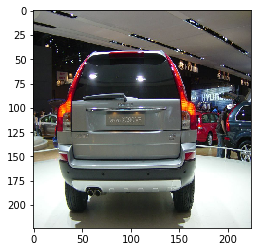

In [33]:
import matplotlib.pyplot as plt
def test():
    path_base = '../Data'

    image = Image.open(path_base + '/car_data/train/Volvo XC90 SUV 2007/00286.jpg')
    #img = image.img_to_array(img)
    image = image.resize((224,224))
    img = np.expand_dims(image, axis=0)
    img = preprocess_input(img)
    
    op = model.predict(img)
    result = op.argmax()
    imgplot = plt.imshow(image)
    
    print(result)
plt.show()
test()

In [34]:
def convert_keras():
    converter = tf.contrib.lite.TocoConverter.from_keras_model_file('model_mobilenetv1.h5')
    converter.post_training_quantize = True
    tflite_model = converter.convert()
    open("cars_mobilenetv1_quant.tflite", "wb").write(tflite_model)

In [35]:
convert_keras()

INFO:tensorflow:Froze 139 variables.
INFO:tensorflow:Converted 139 variables to const ops.


In [31]:
ifle = open('labels_cars.txt','w')
for keyval in train_generator.class_indices.keys():
    ifle.write(keyval)
    ifle.write('\n')
ifle.close()